# Assignment 2 - Music Genre Prediction
Kyle Ah Von #57862609

## Summary
Classifier model for a dataset to predict the genre of a song based on various properties of a song.

If like me, you do not know the difference between the multiple different types of music genres and what song belongs to which, fear no more! Let's build a model to analyze technical features of a song and classify them into the genres they belong. No more guessing genres, this model will give you the answer, all you need is to feed in attributes of a song that you can find one google search away

The genres that we will look into are: Trap, Techno, Techhouse, Trance, Psytrance, Dark Trap, DnB (drums and bass), Hardstyle, Underground Rap, Trap Metal, Emo, Rap, RnB, Pop and Hiphop.

We will investigate features such as danceability, energy, key, loudness, speechiness, acousticness, intrumentalness, liveness and valence amongst others. The dataset contains other features such as duration, time signature, track name, track id and spotify id, these features should not influence the likeness of a song to be a given genre, so they will be ignored.



# Exploring the Dataset
## Importing Libraries and dataset

In [219]:
# Data Manipulation
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations

# Data Visualization
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
import seaborn as sns            # For statistical data visualization

# Machine Learning
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
from sklearn.preprocessing import StandardScaler, MinMaxScaler , PolynomialFeatures # For feature scaling & polynomial regression
from sklearn.svm import SVR  # For Support Vector Regression
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score  # For model evaluation metrics

from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from scipy.stats import loguniform
from scipy.stats import uniform, randint
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, cohen_kappa_score, hamming_loss
import warnings
warnings.filterwarnings("ignore")

musicdata = pd.read_csv('genres_v2.csv')
musicdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   energy            42305 non-null  float64
 2   key               42305 non-null  int64  
 3   loudness          42305 non-null  float64
 4   mode              42305 non-null  int64  
 5   speechiness       42305 non-null  float64
 6   acousticness      42305 non-null  float64
 7   instrumentalness  42305 non-null  float64
 8   liveness          42305 non-null  float64
 9   valence           42305 non-null  float64
 10  tempo             42305 non-null  float64
 11  type              42305 non-null  object 
 12  id                42305 non-null  object 
 13  uri               42305 non-null  object 
 14  track_href        42305 non-null  object 
 15  analysis_url      42305 non-null  object 
 16  duration_ms       42305 non-null  int64 

## Drop unnecessary columns
Dropping: id, uri, track_href, analysis_url, duration_ms, time_signature, song_name, Unnamed: 0, title, mode

In [220]:
data_to_drop = {'id', 'uri', 'analysis_url', 'duration_ms', 'time_signature', 'track_href', 'song_name', 'type', 'Unnamed: 0', 'title', 'mode'}
musicdata = musicdata.drop(data_to_drop, axis = 1)
musicdata.head()


danceability  energy  key  loudness  speechiness  acousticness  \
0         0.831   0.814    2    -7.364       0.4200        0.0598   
1         0.719   0.493    8    -7.230       0.0794        0.4010   
2         0.850   0.893    5    -4.783       0.0623        0.0138   
3         0.476   0.781    0    -4.710       0.1030        0.0237   
4         0.798   0.624    2    -7.668       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo      genre  
0          0.013400    0.0556   0.3890  156.985  Dark Trap  
1          0.000000    0.1180   0.1240  115.080  Dark Trap  
2          0.000004    0.3720   0.0391  218.050  Dark Trap  
3          0.000000    0.1140   0.1750  186.948  Dark Trap  
4          0.000000    0.1660   0.5910  147.988  Dark Trap

## Correlation Matrix
Plot to see if there are any obvious correlation between features to drop redundant features

<AxesSubplot:>

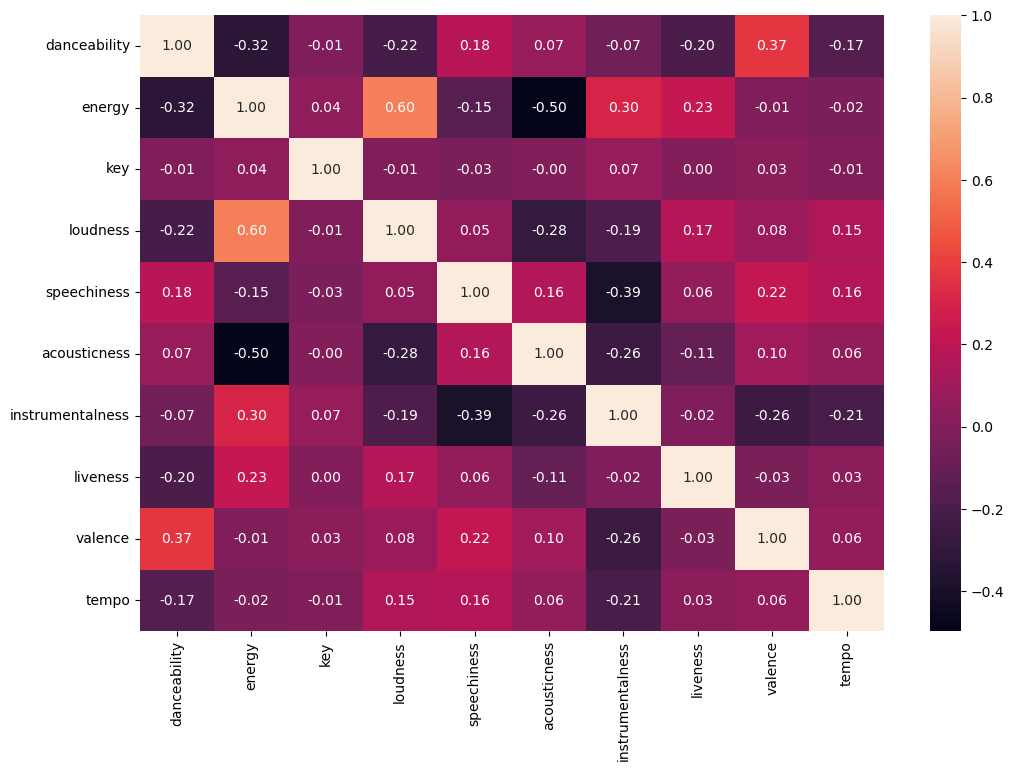

In [221]:
plt.figure(figsize=(12,8))
sns.heatmap(musicdata.corr(), annot=True, fmt='.2f')

There is no strong correlation, hence, we cannot reduce the number of argument/apply PCA. 

Now let's have a visual idea of what the AVERAGE distribution of each category looks like. 

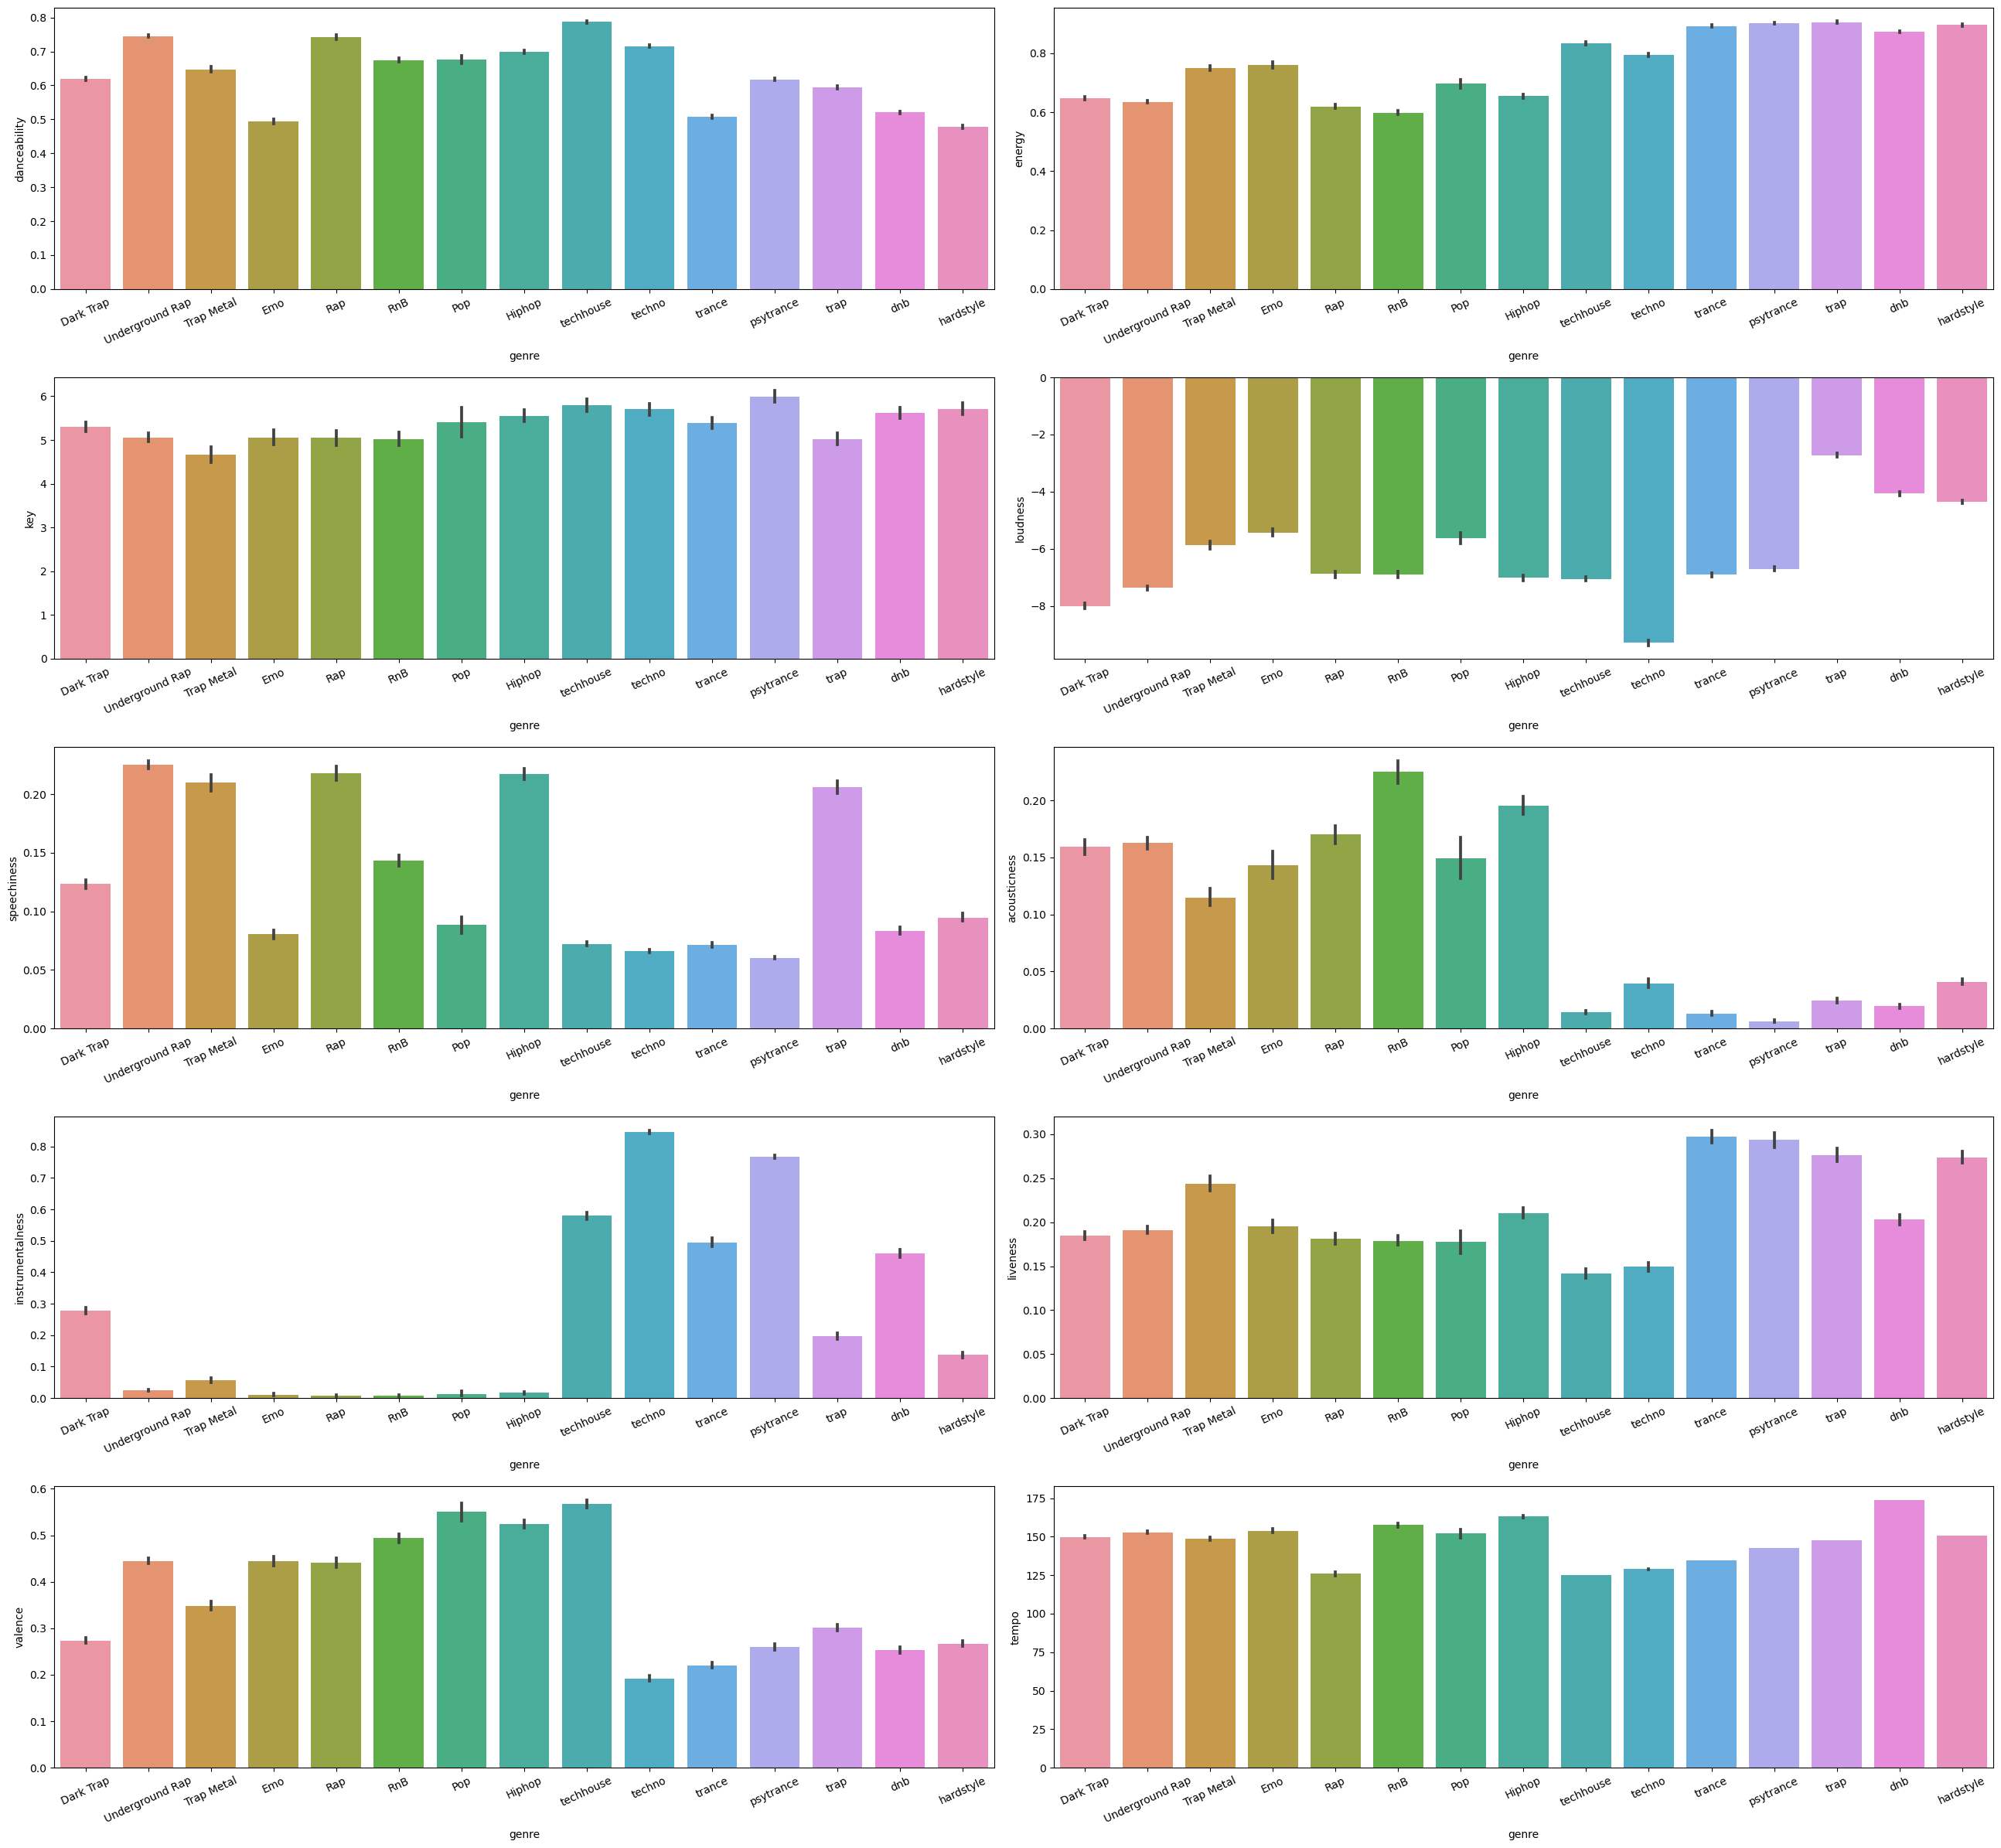

In [222]:
# Get the list of column names
cols = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
# Create a figure and a grid of subplots (3 rows, 4 columns)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(26, 24))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot data on the first 11 subplots
for i in range(len(cols)):
    sns.barplot(data=musicdata, x='genre', y=cols[i], ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=25)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


From the histograms aboves, we can start to see that there are some trends in the data, for example, if a song has a higher level of acousticness, it is unlikely to be dnb or hardstyle. Similarly, if a song has high instrumentalness, it is unlikely to be Rap or RnB amongst others.

## Outliers
Since music is a subjective topic, removing outliers based on a hard threshold might not be the most effective way to prevent abnormal values from influencing our model. It is possible that there is one song that is extremely loud and very danceable which is a Trap song. From the data above, Trap songs seem to be not usually loud and not very danceable. 

We will investigate the boxplots and highlight points that would be considered outliers based on the Interquartile Range technique. 

Number of outliers of danceability : 45
Number of outliers of energy : 139
Number of outliers of key : 0
Number of outliers of loudness : 796
Number of outliers of speechiness : 1918
Number of outliers of acousticness : 5149
Number of outliers of instrumentalness : 0
Number of outliers of liveness : 2496
Number of outliers of valence : 0
Number of outliers of tempo : 532


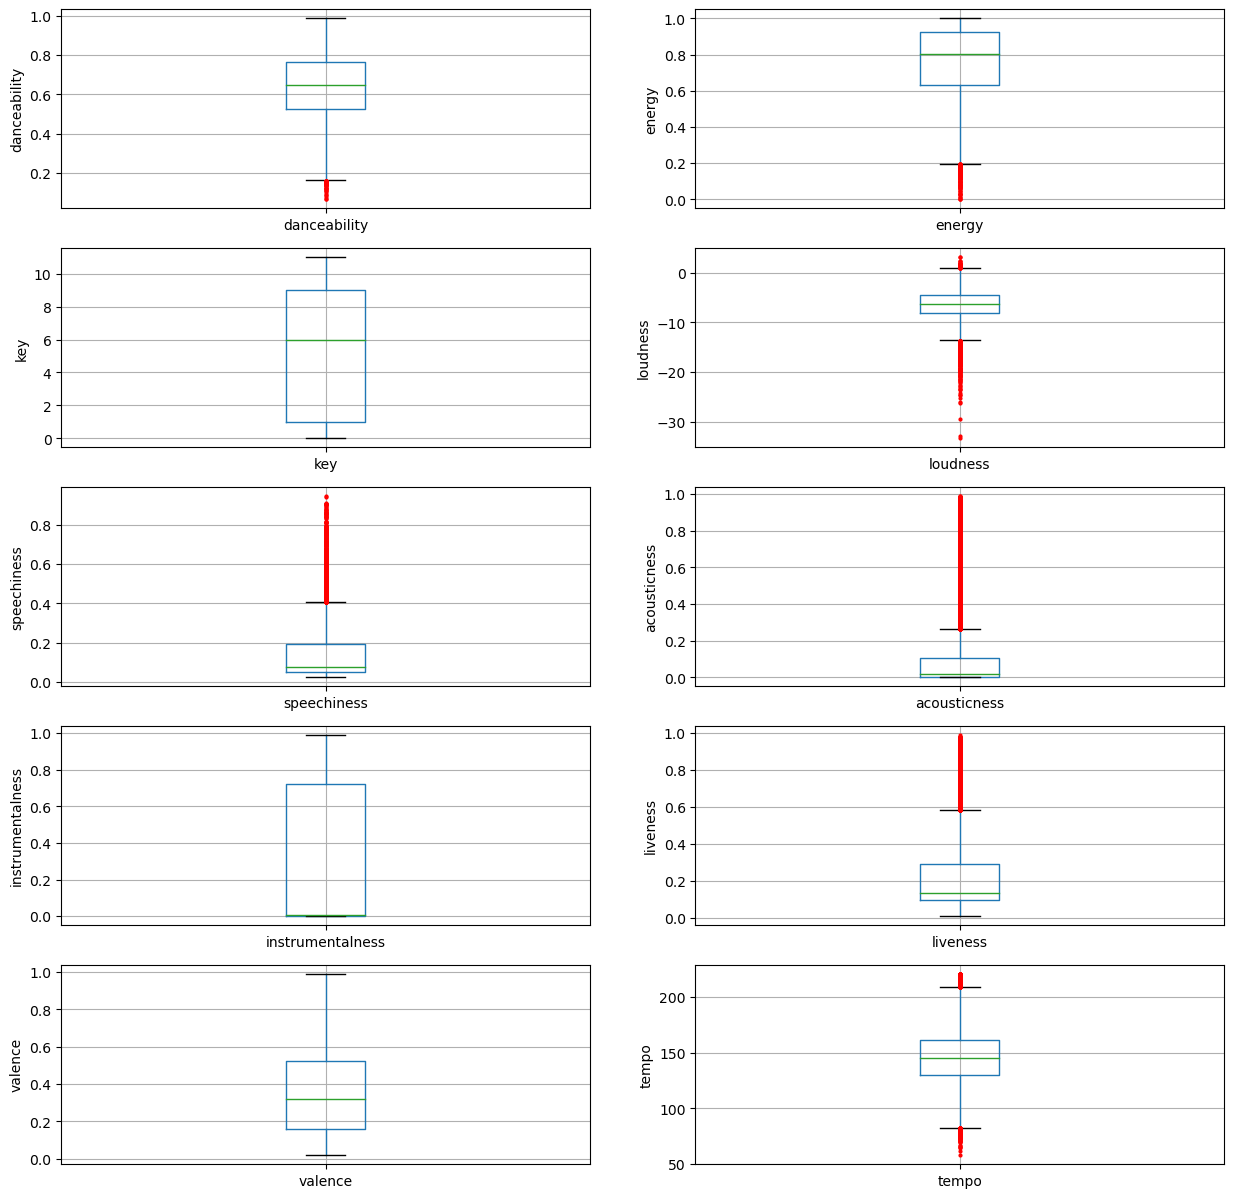

In [223]:
#create a function to find outliers using IQR
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

#Just loop it in the main for loop down below

plt.figure(figsize=(15,15))
# Define flierprops to control outlier size
flierprops = dict(marker='o', markersize=2, markerfacecolor='red', markeredgecolor='red')

for i in range(1, len(cols)+1):
    plt.subplot(5, 2, i)
    fig = musicdata.boxplot(column=cols[i-1], flierprops = flierprops)
    fig.set_title('')
    fig.set_ylabel(cols[i-1])
    print('Number of outliers of ' + cols[i-1] + ' : ' + str(len(find_outliers_IQR(musicdata[cols[i-1]]))))


Using Interquartile ranges to remove outliers might not be the most suitable technique for some of the columns, namely:

| Feature     | Number of Outliers | Percentage of data that is outliers  |
|-------------|--------------------|--------------------------------------|
| speechiness | 1918               | 4.5%                                 |
| acousticness| 5149               | 12.17%                               |
| liveness    | 2496               | 5.9%                                 |
| loudness    | 796                | 1.9%                                 |

Looking at the distribution, we can see that genres like Dark Trap, Rap, and R&B have relatively high acousticness values, while genres like techno, trance, and trap show much lower values.

Given the spread of values across different genres, it's possible that some of the "outliers" are legitimate variations associated with particular genres. For example, extreme values for certain attributes (like acousticness, loudness, etc.) might be characteristic of specific genres rather than anomalies. 

To get a better idea of the distribution of data, we can plot the data using different representations, namely **histograms** and **kernel density estimation** plots. 


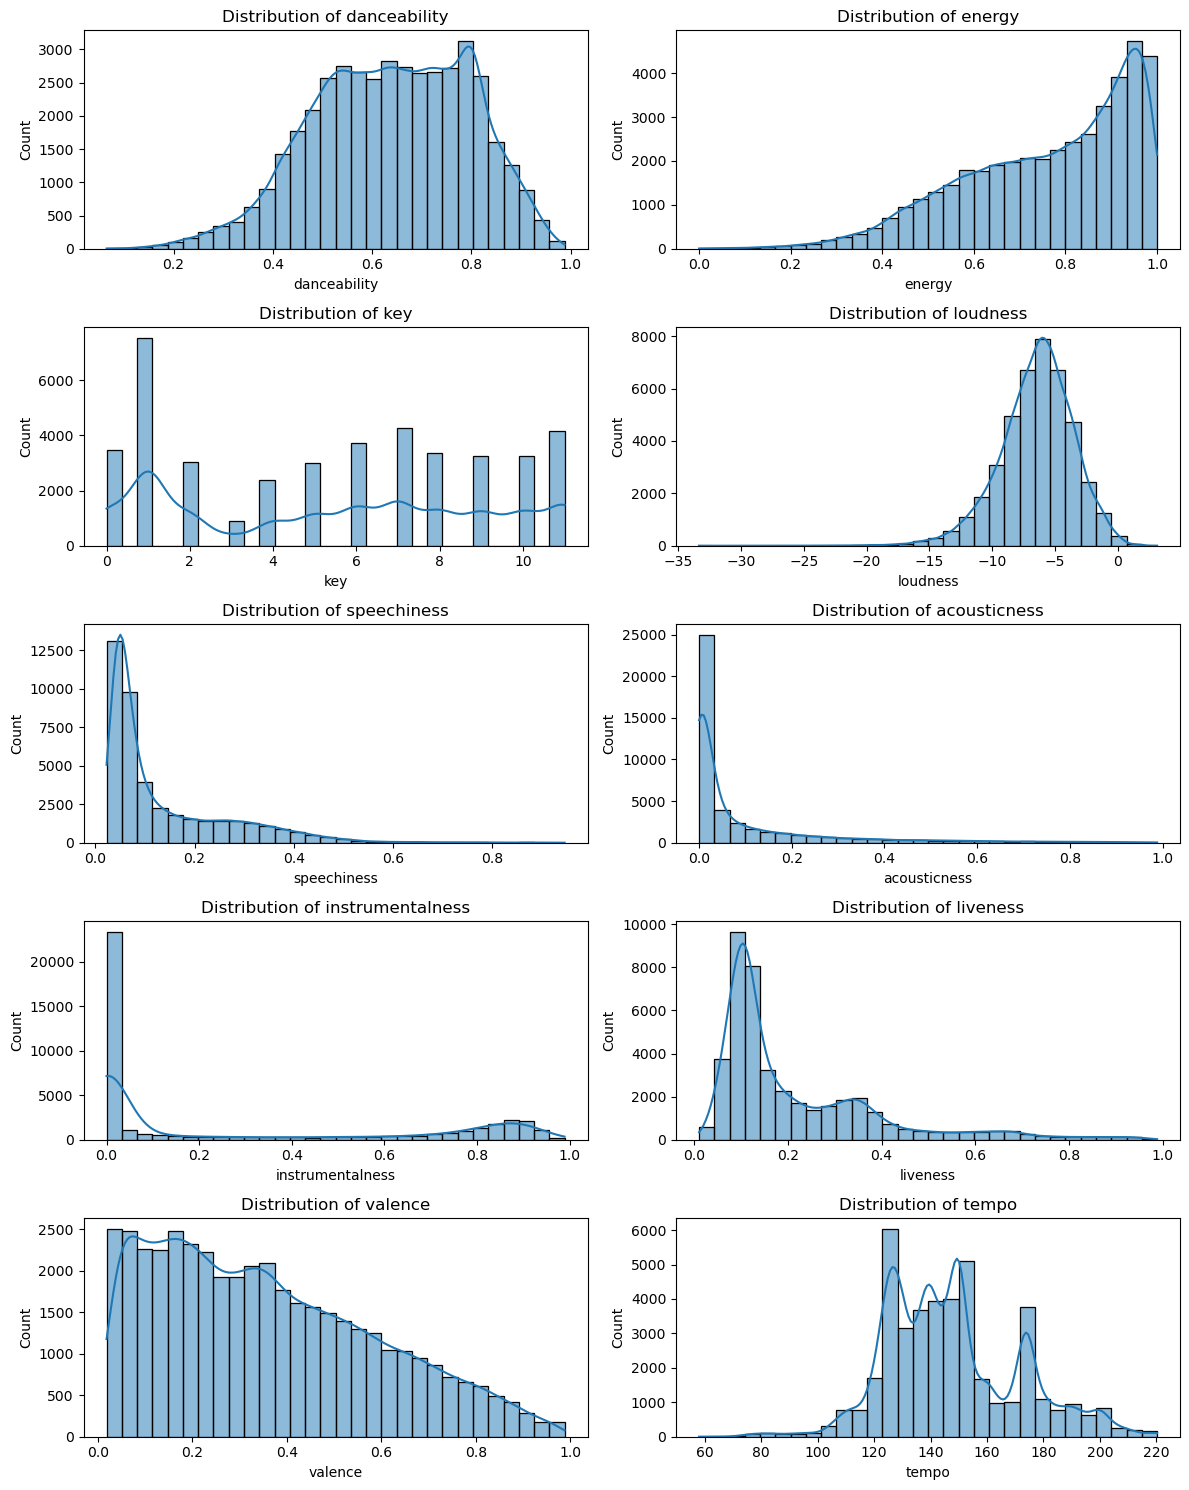

In [224]:
#Histogram plotting 
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easy indexing

# Loop through each column and plot on the corresponding axis
for i, column in enumerate(cols):
    sns.histplot(musicdata[column], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}")

# Adjust layout to make it tight
plt.tight_layout()
plt.show()



Based on the distribution of the data, we will do the following to build the most accurate model as possible:

|   #  | Type of Model                                      | Reason                                                                   |
|------|----------------------------------------------------|--------------------------------------------------------------------------|
|  1   | Train a model without removing outliers            | Some songs have legitimate extreme features and we want to include those |
|  2   | Apply robust scaling                               | Scales the data so it does not contain extreme data points               |
|  3   | Apply IQR outlier removal                          | Applies standard methods to remove outliers                              |


Afterwards, we will compare the test accuracy of the models

# Data Preprocessing
 From exploring the dataset, we can see that there no null/Nan values, hence there is no need to drop row

## Encoding Genre

In [225]:
#Count for each genre before label encoder
musicdata["genre"].value_counts()

Underground Rap    5875
Dark Trap          4578
Hiphop             3028
trance             2999
trap               2987
techhouse          2975
dnb                2966
psytrance          2961
techno             2956
hardstyle          2936
RnB                2099
Trap Metal         1956
Rap                1848
Emo                1680
Pop                 461
Name: genre, dtype: int64

In [226]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
musicdata['genre']= label_encoder.fit_transform(musicdata['genre'])
  
musicdata['genre'].unique()

array([ 0,  7,  6,  1,  4,  5,  3,  2, 11, 12, 13, 10, 14,  8,  9])

In [227]:
#Count for each genre after label encoder
musicdata["genre"].value_counts()

7     5875
0     4578
2     3028
13    2999
14    2987
11    2975
8     2966
10    2961
12    2956
9     2936
5     2099
6     1956
4     1848
1     1680
3      461
Name: genre, dtype: int64

In [228]:
#Split data into feature and target
x = musicdata.drop(['genre'], axis=1)
y = musicdata['genre']
#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state = 42)
#Show the number of data in train and test data
x_train.shape, x_test.shape

((33844, 10), (8461, 10))

In [229]:
x_train.describe()

danceability        energy           key      loudness   speechiness  \
count  33844.000000  33844.000000  33844.000000  33844.000000  33844.000000   
mean       0.639616      0.762889      5.383968     -6.468434      0.136532   
std        0.156316      0.183364      3.660711      2.921052      0.126349   
min        0.065100      0.000243      0.000000    -33.357000      0.022700   
25%        0.525000      0.632000      1.000000     -8.159000      0.049100   
50%        0.646000      0.803000      6.000000     -6.246000      0.075400   
75%        0.767000      0.922000      9.000000     -4.524000      0.193000   
max        0.988000      1.000000     11.000000      3.108000      0.944000   

       acousticness  instrumentalness      liveness       valence  \
count  33844.000000      33844.000000  33844.000000  33844.000000   
mean       0.095660          0.285237      0.214269      0.357271   
std        0.170686          0.371730      0.176104      0.233625   
min        0.000001          0.000000      0.010700      0.018700   
25%        0.001690          0.000000      0.099600      0.161000   
50%        0.016400          0.006150      0.135000      0.321000   
75%        0.106000          0.726250      0.294000      0.522000   
max        0.987000          0.989000      0.988000      0.988000   

              tempo  
count  33844.000000  
mean     147.408835  
std       23.837533  
min       57.967000  
25%      129.862500  
50%      144.964500  
75%      161.145000  
max      220.290000

In [230]:
x_test.describe()

danceability       energy          key     loudness  speechiness  \
count   8461.000000  8461.000000  8461.000000  8461.000000  8461.000000   
mean       0.638358     0.761022     5.315329    -6.453475     0.136674   
std        0.157822     0.185653     3.687508     3.020425     0.125447   
min        0.065100     0.000243     0.000000   -32.929000     0.023500   
25%        0.523000     0.630000     1.000000    -8.166000     0.049500   
50%        0.643000     0.802000     6.000000    -6.186000     0.075900   
75%        0.764000     0.924000     9.000000    -4.449000     0.194000   
max        0.982000     0.999000    11.000000     3.148000     0.946000   

       acousticness  instrumentalness     liveness      valence        tempo  
count   8461.000000       8461.000000  8461.000000  8461.000000  8461.000000  
mean       0.098164          0.274291     0.213321     0.356419   147.734941  
std        0.171382          0.366905     0.173454     0.231504    23.872593  
min        0.000003          0.000000     0.013500     0.019600    64.934000  
25%        0.001910          0.000000     0.099400     0.162000   129.975000  
50%        0.016400          0.005010     0.134000     0.323000   144.985000  
75%        0.113000          0.699000     0.295000     0.520000   162.000000  
max        0.988000          0.981000     0.981000     0.980000   220.216000

## Scaling 
We want to bring all the columns to the same range especially since we have negative values.

In [231]:
cols = x_train.columns
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train = pd.DataFrame(x_train, columns=[cols])
x_test = pd.DataFrame(x_test, columns=[cols])

In [232]:
#Range of x_train after normalization
x_train.describe()

danceability        energy           key      loudness   speechiness  \
count  33844.000000  33844.000000  33844.000000  33844.000000  33844.000000   
mean       0.622511      0.762831      0.489452      0.737380      0.123556   
std        0.169375      0.183408      0.332792      0.080106      0.137142   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.498321      0.631911      0.090909      0.691019      0.028655   
50%        0.629429      0.802952      0.545455      0.743480      0.057202   
75%        0.760537      0.921981      0.818182      0.790703      0.184847   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       acousticness instrumentalness      liveness       valence         tempo  
count  33844.000000     33844.000000  33844.000000  33844.000000  33844.000000  
mean       0.096919         0.288409      0.208297      0.349295      0.551011  
std        0.172935         0.375864      0.180195      0.241025      0.146852  
min        0.000000         0.000000      0.000000      0.000000      0.000000  
25%        0.001711         0.000000      0.090965      0.146807      0.442916  
50%        0.016615         0.006218      0.127187      0.311875      0.535953  
75%        0.107395         0.734328      0.289880      0.519241      0.635634  
max        1.000000         1.000000      1.000000      1.000000      1.000000

In [233]:
#Range of x_test after normalization
x_test.describe()

danceability       energy          key     loudness  speechiness  \
count  8461.000000  8461.000000  8461.000000  8461.000000  8461.000000   
mean      0.621149     0.760964     0.483212     0.737790     0.123710   
std       0.171006     0.185698     0.335228     0.082831     0.136163   
min       0.000000     0.000000     0.000000     0.011737     0.000868   
25%       0.496153     0.629910     0.090909     0.690827     0.029089   
50%       0.626178     0.801952     0.545455     0.745125     0.057744   
75%       0.757287     0.923982     0.818182     0.792760     0.185933   
max       0.993499     0.999000     1.000000     1.001097     1.002171   

      acousticness instrumentalness     liveness      valence        tempo  
count  8461.000000      8461.000000  8461.000000  8461.000000  8461.000000  
mean      0.099456         0.277342     0.207328     0.348415     0.553020  
std       0.173639         0.370985     0.177483     0.238837     0.147068  
min       0.000002         0.000000     0.002865     0.000929     0.042921  
25%       0.001934         0.000000     0.090760     0.147839     0.443609  
50%       0.016615         0.005066     0.126164     0.313938     0.536079  
75%       0.114487         0.706775     0.290904     0.517177     0.640901  
max       1.001013         0.991911     0.992837     0.991747     0.999544

## Models
### KNN (With Outliers)
This is expected to be bad since, outliers have a big influence on this model

In [234]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(1,6):
    KNNclassifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
    KNNclassifier.fit(x_train, y_train)

    y_pred = KNNclassifier.predict(x_train)
    KNN_train_accuracy = accuracy_score(y_train, y_pred)
    print("Accuracy on the training set:", KNN_train_accuracy, "with", i, "neighbor(s).")

Accuracy on the training set: 0.9376255761730292 with 1 neighbor(s).
Accuracy on the training set: 0.7452133317574755 with 2 neighbor(s).
Accuracy on the training set: 0.7054130717409289 with 3 neighbor(s).
Accuracy on the training set: 0.6754225268880747 with 4 neighbor(s).
Accuracy on the training set: 0.6583737146909349 with 5 neighbor(s).


### SVM (With outliers)

In [235]:
from sklearn.svm import SVC
SVMclassifier = SVC(kernel = 'rbf', random_state = 42)
SVMclassifier.fit(x_train, y_train)
y_pred = SVMclassifier.predict(x_test)


In [236]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
SVM_train_accuracy = accuracy_score(y_test, y_pred)
print("SVM accuracy is", SVM_train_accuracy*100, "%")

[[315  14  12   0   0  25   9 367  50  29  33  14  26  59  17]
 [ 15 196   1   0   0  48   2  30  14  16   0   4   0  15   0]
 [ 24  17  85   0   7  51   1 409   5   4   0  13   1   3   1]
 [  4  19   3   0   1  18   0  37   3   2   0   7   1   3   0]
 [ 10   2   2   0  70  11   2 235   2   0   0   3   0   2   2]
 [ 21  20  27   0   0 111   0 198   6   3   0  10   0   0   0]
 [ 35  18   8   0   2   3  34 189  22  18   1   7   0  15  32]
 [ 62  14  29   0   2  26   9 986  10   8   1  18   4  10  13]
 [ 11  18   3   0   0   0   3  15 549   0   0   0   0   0   0]
 [ 20  30   0   0   0   5   0   5   0 474  40   0   0   0  45]
 [ 19   1   0   0   0   0   0   1   0   8 508   0  21  37   3]
 [  5   2   0   0   0   1   0  26   0   0   0 465  56  13   0]
 [ 17   0   0   0   0   0   0   3   0   0  25  54 468  23   0]
 [ 36   8   0   0   0   0   5  10   0   1  19  12  21 448   2]
 [ 17   9   1   0   0   2   1  28   1  72  15   0   0  12 424]]
SVM accuracy is 60.66658787377378 %


### Random Forest Classifier (With outliers)

In [237]:
Forestclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
Forestclassifier.fit(x_train, y_train)
y_pred = Forestclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
RandomTree_train_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest accuracy is", RandomTree_train_accuracy*100, "%")


[[411  14  26   0  17  30  52 268  15  15  27   9  18  46  22]
 [ 17 234  13  10   3  18   4  15   5  11   0   1   0   8   2]
 [ 56  10 189   2  31  64  11 249   1   0   0   4   1   0   3]
 [  6  24  14  14   2  17   0  15   1   0   0   2   0   2   1]
 [ 25   3  40   1 117  22   5 124   0   0   0   2   0   0   2]
 [ 43  23  90  10  17 102   3 105   1   0   0   2   0   0   0]
 [ 78  20  16   1  14   3  65 144   7   7   1   2   2   7  17]
 [195  11 191   5  89  62 117 495   6   3   4   5   2   2   5]
 [  7   5   4   1   0   0   1   1 580   0   0   0   0   0   0]
 [  7   7   0   0   0   0   3   0   0 568   4   0   0   0  30]
 [ 11   0   0   0   0   0   0   1   0  13 529   0  12  29   3]
 [  5   1   0   3   0   1   5   5   0   0   0 513  33   2   0]
 [ 10   0   0   0   0   0   0   1   0   0  28  58 476  16   1]
 [ 20   4   2   0   0   0   6   2   0   1  18   9  19 478   3]
 [ 27   5   2   1   1   3  10   7   0  48   4   0   0   4 470]]
Random Forest accuracy is 61.94303273844699 %


### XgBoost Classifier (With Outliers)

In [238]:
# Initialize and train the XGBoost classifier
xg_classifier = xgb.XGBClassifier(objective ='multi:softmax', num_class=3, random_state=42)
xg_classifier.fit(x_train, y_train)

# Predict the target values for the testing set
y_pred = xg_classifier.predict(x_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
print(cm)
XgB_train_accuracy = accuracy_score(y_test, y_pred)
print("XgBoost accuracy is", XgB_train_accuracy*100, "%")

[[433   8  29   0  11  25  43 293  14  14  16   6  13  39  26]
 [ 16 243  10  10   0  19   3  18   5   6   0   2   0   7   2]
 [ 33  12 185   4  21  67  11 273   2   2   0   5   1   2   3]
 [  6  20  14  11   0  25   2  15   0   0   0   2   0   3   0]
 [  8   3  17   1 106  21   5 174   2   0   0   2   0   1   1]
 [ 27  17  72  11   3 120   3 137   1   2   0   2   0   1   0]
 [ 58  17  11   1   5   7  89 166   2   3   1   1   0   7  16]
 [144  16 134   4  60  49  73 690   2   2   1   6   2   1   8]
 [  1   1   2   1   0   0   0   3 591   0   0   0   0   0   0]
 [  9   3   0   0   0   1   0   0   0 581   3   0   0   0  22]
 [ 10   0   0   0   0   0   0   0   0   7 530   0  15  29   7]
 [  8   0   0   0   0   0   2   8   0   0   0 511  35   4   0]
 [  7   0   0   0   0   0   0   0   0   0  23  57 484  18   1]
 [ 20   0   0   0   0   0   4   5   0   0  12   7  19 491   4]
 [ 19   2   1   0   0   4   8   8   0  33   3   0   0   2 502]]
XgBoost accuracy is 65.79600520033094 %


### Naive Bayes (With Outliers)

In [239]:
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(x_train, y_train)
y_pred = NBclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
NB_train_accuracy = accuracy_score(y_test, y_pred)
print("NB accuracy is", NB_train_accuracy*100, "%")

[[232  65  35   4  76  85  22 214  15  15  42   9  60  71  25]
 [ 13 177   1  12  15  36  10  12  12  22   0   4   0  18   9]
 [ 25  25 160   4  67  91  22 201   3   3   0   8   2   6   4]
 [  2  18   4  16   7  23   3  12   3   1   0   4   0   3   2]
 [ 10  12  10   5 165  20   5 104   2   0   0   3   0   1   4]
 [ 10  40  58  14  49 118   5  83   2   3   0  10   0   1   3]
 [ 23  46  29   2  47  14  48  96   2  12   1   5   0  20  39]
 [ 49  47 112   9 212 107  24 569   2   5   2  12   4  12  26]
 [ 18   9   3   0   0   1  10   2 556   0   0   0   0   0   0]
 [ 13  32   0   0   0   1   1   1   0 474  47   0   0   0  50]
 [  9   0   0   0   0   0   0   1   0   6 514   0  34  29   5]
 [ 12   3   0   0   5   0   2   5   0   0   0 490  45   6   0]
 [ 20   1   0   0   0   0   0   2   0   0  51  67 430  19   0]
 [  7  10   0   1   2   1   4   7   0   0 104  14  29 372  11]
 [  6  14   2   1   1   0   2  17   0 104  28   0   0  26 381]]
NB accuracy is 55.57262734901312 %


### Decision Tree (With outliers)

In [240]:
from sklearn.tree import DecisionTreeClassifier
Treeclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
Treeclassifier.fit(x_train, y_train)
y_pred = Treeclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
DecisionTree_train_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree accuracy is", DecisionTree_train_accuracy*100, "%")

[[312  20  70   1  36  46 109 205  12  14  38   9  29  45  24]
 [ 25 183  18  11   4  30  11  24   8  12   0   4   0   6   5]
 [ 77  18 171   7  47  89  24 170   5   3   1   4   1   1   3]
 [ 11  19   9  11   7  18   3  17   1   0   0   1   0   1   0]
 [ 32   4  55   1 132  29  11  73   2   0   0   1   0   0   1]
 [ 40  27 109  17  18 103  19  56   2   0   1   1   0   3   0]
 [100  22  24   3  17   9  64 111   3   3   1   2   3   7  15]
 [259  22 211  10 130  78 131 317   4   4   3   4   5   3  11]
 [  7   2   5   0   0   1   3   8 573   0   0   0   0   0   0]
 [ 27   7   0   0   1   0   7   2   0 530   4   0   0   0  41]
 [ 25   1   0   0   0   0   3   3   0  14 482   0  18  37  15]
 [ 10   1   2   4   0   2   6   3   0   0   0 479  57   4   0]
 [ 29   0   1   0   0   0   2   0   0   0  28  69 428  31   2]
 [ 51   8   4   1   1   0   5   1   0   0  30  10  27 421   3]
 [ 29  12   3   0   3   3  18   9   0  52  11   1   1   4 436]]
Decision Tree accuracy is 54.86349131308356 %


# Dealing with Outliers
## Robust Scaling
Now let's deal with outliers and rerun our models

Let's rescale the data with a lot of outliers using robust scaling, so it minimizes the effects of outliers while still keeping the information. 

Robust scaling is a preprocessing technique that scales features using statistics that are robust to outliers, specifically the median and interquartile range (IQR). Unlike standard scaling, which uses mean and standard deviation, robust scaling is less influenced by extreme values. You might use robust scaling in your model because your data distributions, as shown in the histograms, have varying shapes and some potential outliers. For instance, the 'speechiness', 'acousticness', and 'instrumentalness' features show highly skewed distributions with potential outliers. Robust scaling would help normalize these features without letting the outliers disproportionately influence the scaling, potentially improving your model's performance, especially for algorithms sensitive to feature scales like SVMs or neural networks.


In [241]:
from sklearn.preprocessing import RobustScaler

x_train_robust, x_test_robust, y_train_robust, y_test_robust = train_test_split(x, y, test_size = 0.2,random_state = 42)

cols = x_train_robust.columns
scaler = RobustScaler()
x_train_robust = scaler.fit_transform(x_train_robust)
x_test_robust = scaler.transform(x_test_robust)
x_train_robust = pd.DataFrame(x_train_robust, columns=[cols])
x_test_robust = pd.DataFrame(x_test_robust, columns=[cols])

## Models
### KNN (Robust Scaler)
This is expected to be bad since, outliers have a big influence on this model

In [242]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(1,6):
    KNNclassifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
    KNNclassifier.fit(x_train_robust, y_train_robust)

    y_pred = KNNclassifier.predict(x_train_robust)
    KNN_train_accuracy = accuracy_score(y_train_robust, y_pred)
    print("Accuracy on the training set:", KNN_train_accuracy, "with", i, "neighbor(s).")

Accuracy on the training set: 0.9377437655123508 with 1 neighbor(s).
Accuracy on the training set: 0.7575641177165819 with 2 neighbor(s).
Accuracy on the training set: 0.7194776031201986 with 3 neighbor(s).
Accuracy on the training set: 0.695248788559272 with 4 neighbor(s).
Accuracy on the training set: 0.6793523224205177 with 5 neighbor(s).


### SVM (Robust Scaler)

In [243]:
from sklearn.svm import SVC
SVMclassifier = SVC(kernel = 'rbf', random_state = 42)
SVMclassifier.fit(x_train_robust, y_train_robust)
y_pred = SVMclassifier.predict(x_test_robust)


In [244]:
cm = confusion_matrix(y_test_robust, y_pred)
print(cm)
SVM_train_accuracy = accuracy_score(y_test_robust, y_pred)
print("SVM accuracy is", SVM_train_accuracy*100, "%")

[[356  13  16   0   0  21  12 349  30  39  26  19  24  42  23]
 [ 19 198   3   0   0  43   4  24   9  24   0   5   0  10   2]
 [ 35  16 138   1   7  53   2 344   8   2   0   8   1   3   3]
 [  4  19   5   0   0  25   0  30   2   3   0   6   0   4   0]
 [  8   3   6   0  78  14   2 220   3   0   0   4   0   1   2]
 [ 28  16  39   0   0 116   1 177   4   5   0   9   0   1   0]
 [ 44  13  12   0   1   6  38 174  18  17   1   8   0  13  39]
 [ 73  10  69   0   3  33  16 926   9   9   2  19   3   7  13]
 [  9  15   2   0   0   0   3  14 555   1   0   0   0   0   0]
 [ 22  12   1   0   0   2   0   2   0 510  18   0   0   0  52]
 [ 18   1   0   0   0   0   0   2   0  17 502   0  18  36   4]
 [  8   2   0   0   0   1   0  19   0   0   0 484  45   8   1]
 [ 14   0   0   0   0   0   0   2   0   0  28  55 466  24   1]
 [ 41   4   0   0   0   0   3   6   0   1  14   6  22 462   3]
 [ 15   6   1   1   0   1   2  23   0  66  11   0   0  13 443]]
SVM accuracy is 62.30941969034392 %


### Random Forest Classifier (Robust Scaler)

In [245]:
Forestclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
Forestclassifier.fit(x_train_robust, y_train_robust)
y_pred = Forestclassifier.predict(x_test_robust)
cm = confusion_matrix(y_test_robust, y_pred)
print(cm)
RandomTree_train_accuracy = accuracy_score(y_test_robust, y_pred)
print("Random Tree accuracy is", RandomTree_train_accuracy*100, "%")


[[394  13  34   0  21  35  59 261  17  16  26   6  16  49  23]
 [ 16 235  14  12   5  15   5  13   5  12   0   1   0   6   2]
 [ 50  11 195   1  34  69  11 238   4   0   0   3   1   0   4]
 [  5  23  13  13   2  19   0  17   1   0   0   1   0   3   1]
 [ 30   4  41   1 115  26   9 112   0   0   0   2   0   0   1]
 [ 35  20  98  13  19 104   1 103   1   0   0   2   0   0   0]
 [ 85  19  15   2  10   5  64 146   4   8   1   5   1   6  13]
 [210  18 187   5  90  54 108 491   4   3   3   6   2   3   8]
 [  5   2   2   1   0   0   4   4 581   0   0   0   0   0   0]
 [  5   7   0   0   0   0   2   1   0 573   3   0   1   1  26]
 [ 17   0   0   0   0   0   0   0   0  11 524   0  12  27   7]
 [  9   0   0   2   1   1   5   4   0   0   0 503  40   3   0]
 [ 11   0   0   0   0   0   0   1   0   0  28  54 478  17   1]
 [ 27   4   3   0   0   0   3   5   0   0  18   9  21 470   2]
 [ 21   6   2   0   1   2   9  10   0  47   8   0   0   6 470]]
Random Tree accuracy is 61.57664578655005 %


### XgBoost Classifier (Robust Scaler)

In [246]:
# Initialize and train the XGBoost classifier
xg_classifier = xgb.XGBClassifier(objective ='multi:softmax', num_class=3, random_state=42)
xg_classifier.fit(x_train_robust, y_train_robust)

# Predict the target values for the testing set
y_pred = xg_classifier.predict(x_test_robust)

# Evaluate the model
cm = confusion_matrix(y_test_robust, y_pred)
print(cm)
XgB_train_accuracy = accuracy_score(y_test_robust, y_pred)
print("XgBoost accuracy is", XgB_train_accuracy*100, "%")

[[433   8  29   0  11  25  43 293  14  14  16   6  13  39  26]
 [ 16 243  10  10   0  19   3  18   5   6   0   2   0   7   2]
 [ 33  12 185   4  21  67  11 273   2   2   0   5   1   2   3]
 [  6  20  14  11   0  25   2  15   0   0   0   2   0   3   0]
 [  8   3  17   1 106  21   5 174   2   0   0   2   0   1   1]
 [ 27  17  72  11   3 120   3 137   1   2   0   2   0   1   0]
 [ 58  17  11   1   5   7  89 166   2   3   1   1   0   7  16]
 [144  16 134   4  60  49  73 690   2   2   1   6   2   1   8]
 [  1   1   2   1   0   0   0   3 591   0   0   0   0   0   0]
 [  9   3   0   0   0   1   0   0   0 581   3   0   0   0  22]
 [ 10   0   0   0   0   0   0   0   0   7 530   0  15  29   7]
 [  8   0   0   0   0   0   2   8   0   0   0 511  35   4   0]
 [  7   0   0   0   0   0   0   0   0   0  23  57 484  18   1]
 [ 20   0   0   0   0   0   4   5   0   0  12   7  19 491   4]
 [ 19   2   1   0   0   4   8   8   0  33   3   0   0   2 502]]
XgBoost accuracy is 65.79600520033094 %


### Naive Bayes (Robust Scaler)

In [247]:
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(x_train_robust, y_train_robust)
y_pred = NBclassifier.predict(x_test_robust)
cm = confusion_matrix(y_test_robust, y_pred)
print(cm)
NB_train_accuracy = accuracy_score(y_test_robust, y_pred)
print("NB accuracy is", NB_train_accuracy*100, "%")

[[232  65  35   4  76  85  22 214  15  15  42   9  60  71  25]
 [ 13 177   1  12  15  36  10  12  12  22   0   4   0  18   9]
 [ 25  25 160   4  67  91  22 201   3   3   0   8   2   6   4]
 [  2  18   4  16   7  23   3  12   3   1   0   4   0   3   2]
 [ 10  12  10   5 165  20   5 104   2   0   0   3   0   1   4]
 [ 10  40  58  14  49 118   5  83   2   3   0  10   0   1   3]
 [ 23  46  29   2  47  14  48  96   2  12   1   5   0  20  39]
 [ 49  47 112   9 212 107  24 569   2   5   2  12   4  12  26]
 [ 18   9   3   0   0   1  10   2 556   0   0   0   0   0   0]
 [ 13  32   0   0   0   1   1   1   0 474  47   0   0   0  50]
 [  9   0   0   0   0   0   0   1   0   6 514   0  34  29   5]
 [ 12   3   0   0   5   0   2   5   0   0   0 490  45   6   0]
 [ 20   1   0   0   0   0   0   2   0   0  51  67 430  19   0]
 [  7  10   0   1   2   1   4   7   0   0 104  14  29 372  11]
 [  6  14   2   1   1   0   2  17   0 104  28   0   0  26 381]]
NB accuracy is 55.57262734901312 %


### Decision Tree (Robust Scaler)

In [248]:
from sklearn.tree import DecisionTreeClassifier
Treeclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
Treeclassifier.fit(x_train_robust, y_train_robust)
y_pred = Treeclassifier.predict(x_test_robust)
cm = confusion_matrix(y_test_robust, y_pred)
print(cm)
DecisionTree_train_accuracy = accuracy_score(y_test_robust, y_pred)
print("Decision Tree accuracy is", DecisionTree_train_accuracy*100, "%")

[[317  15  65   1  33  47 108 214  13  14  35   7  30  39  32]
 [ 22 184  13  16   3  33  12  20   6  12   0   4   0  10   6]
 [ 73  14 175  10  48  84  24 179   4   0   1   4   1   1   3]
 [ 11  19   9  13   5  18   4  15   1   0   0   1   0   1   1]
 [ 30   5  55   2 132  26  12  75   2   0   0   2   0   0   0]
 [ 40  25 103  12  24 107  17  59   2   0   0   2   1   3   1]
 [104  21  21   4  15  11  65 104   4   3   2   2   3   7  18]
 [261  21 215   8 130  84 126 304   4   3   3   4   4   8  17]
 [  6   3   6   0   0   1   3   6 574   0   0   0   0   0   0]
 [ 27   8   0   0   0   0   9   5   0 531   3   0   0   0  36]
 [ 20   2   0   0   0   0   2   2   0  14 492   0  16  33  17]
 [ 10   1   2   5   0   1   5   3   0   0   0 482  55   4   0]
 [ 28   0   2   0   0   0   3   3   0   0  24  67 428  33   2]
 [ 50   5   1   1   1   1   4   2   0   0  29   9  30 426   3]
 [ 31  10   3   0   1   5  19   9   0  52   9   1   0   6 436]]
Decision Tree accuracy is 55.14714572745538 %


## Remove outliers using IQR

Using the Interquartile Range (IQR) method to remove outliers is another approach to deal with extreme values in your data. The IQR is the range between the first quartile (25th percentile) and the third quartile (75th percentile) of your data. Typically, values falling below Q1 - 1.5IQR or above Q3 + 1.5IQR are considered outliers and can be removed or capped. This method could be particularly useful for your features like 'loudness', 'speechiness', and 'liveness', where you've identified a significant number of outliers. By removing these extreme values, you can prevent them from unduly influencing your model's learning process. However, it's crucial to consider whether these "outliers" might actually represent important, rare cases in music genres before deciding to remove them.

In [249]:
# Removing outliers
Q1 = musicdata['acousticness'].quantile(0.25)
Q3 = musicdata['acousticness'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds of the IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the column
musicdata = musicdata[(musicdata['acousticness'] >= lower_bound) & (musicdata['acousticness'] <= upper_bound)]

In [250]:
# Removing outliers
Q1 = musicdata['energy'].quantile(0.25)
Q3 = musicdata['energy'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds of the IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the column
musicdata = musicdata[(musicdata['energy'] >= lower_bound) & (musicdata['energy'] <= upper_bound)]

In [251]:
# Removing outliers
Q1 = musicdata['loudness'].quantile(0.25)
Q3 = musicdata['loudness'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds of the IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the column
musicdata = musicdata[(musicdata['loudness'] >= lower_bound) & (musicdata['loudness'] <= upper_bound)]

In [252]:
# Removing outliers
Q1 = musicdata['danceability'].quantile(0.25)
Q3 = musicdata['danceability'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds of the IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the column
musicdata = musicdata[(musicdata['danceability'] >= lower_bound) & (musicdata['danceability'] <= upper_bound)]

In [253]:
# Removing outliers
Q1 = musicdata['liveness'].quantile(0.25)
Q3 = musicdata['liveness'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds of the IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the column
musicdata = musicdata[(musicdata['liveness'] >= lower_bound) & (musicdata['liveness'] <= upper_bound)]

In [254]:
# Removing outliers
Q1 = musicdata['speechiness'].quantile(0.25)
Q3 = musicdata['speechiness'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds of the IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the column
musicdata = musicdata[(musicdata['speechiness'] >= lower_bound) & (musicdata['speechiness'] <= upper_bound)]

In [255]:
# Removing outliers
Q1 = musicdata['tempo'].quantile(0.25)
Q3 = musicdata['tempo'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds of the IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the column
musicdata = musicdata[(musicdata['tempo'] >= lower_bound) & (musicdata['tempo'] <= upper_bound)]

## Scaling 
We want to bring all the columns to the same range especially since we have negative values.

In [256]:
#Split data into feature and target
x = musicdata.drop(['genre'], axis=1)
y = musicdata['genre']
#train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state = 42)
cols = x_train.columns
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train = pd.DataFrame(x_train, columns=[cols])
x_test = pd.DataFrame(x_test, columns=[cols])

In [257]:
#Range of x_train after normalization
x_train.describe()

danceability        energy           key      loudness   speechiness  \
count  25580.000000  25580.000000  25580.000000  25580.000000  25580.000000   
mean       0.577010      0.713416      0.490863      0.497970      0.249025   
std        0.186927      0.220239      0.332765      0.180240      0.253530   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.437500      0.557103      0.090909      0.380681      0.072477   
50%        0.581731      0.767409      0.545455      0.506366      0.131455   
75%        0.730769      0.902507      0.818182      0.622946      0.342723   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       acousticness instrumentalness      liveness       valence         tempo  
count  25580.000000     25580.000000  25580.000000  25580.000000  25580.000000  
mean       0.150021         0.327844      0.290135      0.343363      0.515130  
std        0.231351         0.384394      0.213106      0.243367      0.176692  
min        0.000000         0.000000      0.000000      0.000000      0.000000  
25%        0.004276         0.000003      0.139103      0.139707      0.375585  
50%        0.033632         0.041658      0.195270      0.301987      0.487312  
75%        0.191285         0.787664      0.425193      0.510299      0.624835  
max        1.000000         1.000000      1.000000      1.000000      1.000000

In [258]:
#Range of x_test after normalization
x_test.describe()

danceability       energy          key     loudness  speechiness  \
count  6396.000000  6396.000000  6396.000000  6396.000000  6396.000000   
mean      0.583082     0.714682     0.493334     0.497982     0.248964   
std       0.186724     0.220464     0.333627     0.178634     0.253487   
min      -0.001202     0.001393     0.000000     0.001707     0.000000   
25%       0.443510     0.557103     0.090909     0.380023     0.071596   
50%       0.590144     0.770195     0.545455     0.504339     0.130575   
75%       0.734375     0.901114     0.818182     0.621630     0.354460   
max       1.000000     0.998607     1.000000     0.994452     1.000000   

       acousticness instrumentalness     liveness      valence        tempo  
count  6.396000e+03      6396.000000  6396.000000  6396.000000  6396.000000  
mean   1.443584e-01         0.324050     0.290222     0.347919     0.516242  
std    2.261394e-01         0.383809     0.210933     0.242550     0.178507  
min    2.651526e-07         0.000000    -0.002299     0.005097     0.012471  
25%    4.276267e-03         0.000003     0.139555     0.146988     0.367877  
50%    3.166274e-02         0.035541     0.196912     0.308228     0.496402  
75%    1.768906e-01         0.785642     0.428478     0.519661     0.625684  
max    1.000000e+00         0.989889     0.996715     1.008322     0.998822

## Models
### KNN (No outliers)
This is expected to be bad since, outliers have a big influence on this model

In [259]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(1,6):
    KNNclassifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
    KNNclassifier.fit(x_train, y_train)

    y_pred = KNNclassifier.predict(x_train)
    KNN_train_accuracy = accuracy_score(y_train, y_pred)
    print("Accuracy on the training set:", KNN_train_accuracy, "with", i, "neighbor(s).")



Accuracy on the training set: 0.9442533229085223 with 1 neighbor(s).
Accuracy on the training set: 0.7632134480062549 with 2 neighbor(s).
Accuracy on the training set: 0.7220093823299453 with 3 neighbor(s).
Accuracy on the training set: 0.6965989053948397 with 4 neighbor(s).
Accuracy on the training set: 0.6819390148553558 with 5 neighbor(s).


### SVM (No Outliers)

In [260]:
from sklearn.svm import SVC
SVMclassifier = SVC(kernel = 'rbf', random_state = 42)
SVMclassifier.fit(x_train, y_train)
y_pred = SVMclassifier.predict(x_test)


In [261]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
SVM_train_accuracy = accuracy_score(y_test, y_pred)
print("SVM accuracy is", SVM_train_accuracy*100, "%")

[[190  11   3   0   1  16   4 183  34  20  27  19  13  39  13]
 [ 16 168   5   0   0  16   1  12  22  19   0   5   0   7   2]
 [ 10   7  60   0   2  18   2 264   9   6   0  11   0   3   3]
 [  2  11   7   0   0  11   0  20   3   0   0   4   1   4   0]
 [  4   3   4   0  28   6   0 166   1   2   0   3   0   0   0]
 [ 12  10  33   1   0  48   1 131   5   3   0  10   0   2   1]
 [ 30  10  10   0   0   2   7 119  13  15   1   5   0  15  20]
 [ 51   9  49   0   0  22   5 557  17   8   2  19   2   6   7]
 [  3  21   1   0   0   0   0  14 491   0   0   0   0   0   0]
 [ 21  17   0   0   0   1   0  10   0 387  21   0   0   0  36]
 [ 17   0   0   0   0   0   0   0   0   5 466   0  15  23  11]
 [  4   5   0   0   0   2   2  15   0   0   0 498  53  13   0]
 [  7   0   0   0   0   0   0   2   0   0  19  56 401  29   1]
 [ 32   9   0   0   0   0   1   8   0   0  30   7  19 400   1]
 [ 12   9   0   0   0   1   1  19   2  60  15   0   0   5 319]]
SVM accuracy is 62.851782363977485 %


### Random Forest Classifier (No Outliers)

In [262]:
Forestclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
Forestclassifier.fit(x_train, y_train)
y_pred = Forestclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
RandomTree_train_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest accuracy is", RandomTree_train_accuracy*100, "%")


[[220  11  14   0  10  14  33 149  15  15  20  13  11  34  14]
 [ 11 199   6   9   1  12   6  11   5   6   0   4   0   3   0]
 [ 33   8 104   5  23  41  11 156   2   1   0   4   0   1   6]
 [  9  12   5   8   1  10   0  10   2   1   0   2   0   3   0]
 [ 14   4  22   3  54   8   6 101   0   0   0   2   0   1   2]
 [ 17  15  63  11  16  57   3  64   1   2   0   6   0   2   0]
 [ 62  15  19   0   4   5  32  79   6   6   1   3   0   5  10]
 [132   6 115   7  60  40  76 290   5   2   3   7   0   3   8]
 [  3   3   1   1   0   0   0   1 521   0   0   0   0   0   0]
 [  8   6   1   0   0   1   0   0   0 449   5   0   0   0  23]
 [ 14   0   0   0   0   0   0   1   0   5 477   0  14  16  10]
 [  6   1   3   1   0   0   1   1   0   1   0 534  41   3   0]
 [  6   0   0   0   0   0   0   0   0   0  16  51 415  26   1]
 [ 23   5   1   1   0   0   0   6   0   0  19   4  21 427   0]
 [ 19   0   0   1   0   0  12  11   0  38   9   1   0   4 348]]
Random Forest accuracy is 64.64978111319574 %


### XgBoost Classifier (No Outliers)

In [263]:
# Initialize and train the XGBoost classifier
xg_classifier = xgb.XGBClassifier(objective ='multi:softmax', num_class=3, random_state=42)
xg_classifier.fit(x_train, y_train)

# Predict the target values for the testing set
y_pred = xg_classifier.predict(x_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
print(cm)
XgB_train_accuracy = accuracy_score(y_test, y_pred)
print("XgBoost accuracy is", XgB_train_accuracy*100, "%")

[[249   6  12   0   9   9  27 156  10  16  16  10   8  30  15]
 [  9 198   7  13   0  12   6  12   5   4   0   3   0   4   0]
 [ 22   9 101   4  16  37   9 190   1   0   0   2   0   2   2]
 [  2  12   8   5   2  16   1  10   2   1   0   1   0   3   0]
 [ 10   4  11   2  56   6   0 124   1   1   0   1   0   1   0]
 [ 15  11  58  13  12  63   4  77   0   0   0   1   0   2   1]
 [ 51  10   7   0   2   3  48 103   3   4   0   2   0   4  10]
 [ 98   6 103   6  54  30  60 378   3   1   5   3   1   1   5]
 [  2   3   0   1   0   0   0   1 523   0   0   0   0   0   0]
 [  5   3   1   0   0   0   0   1   0 457   3   0   0   0  23]
 [  8   0   0   0   0   0   0   1   0   4 482   0  12  18  12]
 [  7   2   0   0   0   0   0   0   0   0   0 535  43   5   0]
 [  3   0   0   0   0   0   0   1   0   0  13  51 423  23   1]
 [ 19   3   0   0   0   0   0   1   0   0  10   5  17 451   1]
 [ 16   1   0   0   0   0   7   9   0  31  10   0   0   1 368]]
XgBoost accuracy is 67.80800500312696 %


### Naive Bayes (No Outliers)

In [264]:
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(x_train, y_train)
y_pred = NBclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
NB_train_accuracy = accuracy_score(y_test, y_pred)
print("NB accuracy is", NB_train_accuracy*100, "%")

[[153  42  14   2  41  48  10  99   8   9  33  14  38  47  15]
 [  9 197   5   8   4  18   3   2   3  14   0   1   0   5   4]
 [  8  27 139   4  56  61   3  83   2   0   0   3   0   5   4]
 [  2  19   9   2   7  17   0   2   1   0   0   1   0   3   0]
 [  3   6  17   2 102  19   2  59   2   1   0   1   0   1   2]
 [ 10  27  40   9  38  78   2  43   2   0   0   5   0   1   2]
 [ 27  36  27   0  32   9  16  50   2   5   3   6   0   8  26]
 [ 45  31 150   9 140  76  12 248   4   3   2  12   1  10  11]
 [ 13  15   4   1   0   4   6   3 484   0   0   0   0   0   0]
 [ 11  22   1   0   0   6   2   2   0 368  31   0   0   1  49]
 [ 10   0   0   0   0   0   2   0   0   2 457   0  36  21   9]
 [ 12   8   0   0   3   2   3   6   0   0   0 478  70  10   0]
 [ 16   0   0   0   0   1   0   2   0   0  22  47 395  31   1]
 [ 11  14   0   0   4   2   0   4   0   0 101   9  35 321   6]
 [ 10  21   1   0   1   3   2   9   0  84  22   0   0   9 281]]
NB accuracy is 58.14571607254534 %


### Decision Tree (No outliers)

In [265]:
from sklearn.tree import DecisionTreeClassifier
Treeclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
Treeclassifier.fit(x_train, y_train)
y_pred = Treeclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
DecisionTree_train_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree accuracy is", DecisionTree_train_accuracy*100, "%")

[[197  16  37   3  18  24  62  86   8  20  19  12  19  35  17]
 [ 15 163  10  14   2  18  17  14   3   5   0   1   0   3   8]
 [ 56   5 103  11  24  48  20 117   3   1   1   0   1   0   5]
 [  5  12   4   4   4  16   4   6   1   1   0   2   0   3   1]
 [ 33   2  26   4  60  15   9  64   0   1   1   2   0   0   0]
 [ 27   9  63  13  19  61  10  47   1   0   0   2   1   3   1]
 [ 81  18  14   5   0   7  29  72   1   3   0   1   0   4  12]
 [160  13 132   8  80  54  92 188   1   3   5   7   1   1   9]
 [  6   3   2   1   1   2   2   0 513   0   0   0   0   0   0]
 [ 13  14   0   0   2   2   3   6   0 402   2   0   0   0  49]
 [ 20   0   0   0   0   0   0   0   0   4 453   1  23  21  15]
 [  9   1   2   3   0   2   3   0   0   0   0 509  58   5   0]
 [ 21   0   0   0   0   0   2   0   0   0  24  63 369  34   2]
 [ 35  12   1   3   2   1   5   0   0   0  25   5  46 369   3]
 [ 27   2   3   0   4   1  14   6   0  36  17   0   0   0 333]]
Decision Tree accuracy is 58.677298311444645 %


# Conclusion and Results

After running models with three conditions: 

|   #  | Type of Model                                                                                  | Reason                                                                   |
|------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------|
|  1   | Train a model without removing outliers (Random Forest/XGBoost - more resistant to outliers)   | Some songs have legitimate extreme features and we want to include those |
|  2   | Apply robust scaling                                                                           | Scales the data so it does not contain extreme data points               |
|  3   | Apply IQR outlier removal                                                                      | Applies standard methods to remove outliers                              |


Here are the compiled results

| Type of Model   | Keep All Outliers (%) | Robust Scaler (%) | IQR Outlier Processing (%) |
|-----------------|-----------------------|-------------------|----------------------------|
| KNN             | 93.7                  | 94.4              | 94.4                       |
| SVM             | 60.7                  | 62.3              | 62.9                       |
| Random Forest   | 61.9                  | 61.6              | 64.7                       |
| XgBoost         | 65.8                  | 65.8              | 67.8                       |
| Naive Bayes     | 55.6                  | 55.6              | 58.1                       |
| Decision Tree   | 54.9                  | 55.1              | 58.7                       |


From the table we can see that generally speaking, using the IQR to identify and remove outliers resulted in slightly better accuracy in our classifier models. Robust scaler was only slightly better at a couple models only. What is impressive is that KNN with only 1 neighbor had a very high accuracy. It can be attributed to the fact that songs with similar genres have very similar features and thus when the prediction is made by looking at which data point the test point is closest too is often enough to make a good prediction. 

#### Overfitting and underfitting
In developing this music genre classification model, we took several steps to balance between overfitting and underfitting. To prevent overfitting, we carefully selected relevant audio features and used robust scaling to handle outliers without letting them overly influence our model. This approach helps ensure our model doesn't just memorize the training data but learns meaningful patterns.
To avoid underfitting, we included a rich set of audio characteristics in our feature set, from danceability to instrumentalness, giving our model enough information to make accurate predictions. We also experimented with different model parameters to find the right level of complexity.
By using the Interquartile Range (IQR) method to handle extreme values, we further refined our dataset, helping the model focus on the most representative data points. This balanced approach aims to create a model that can effectively classify music genres while generalizing well to new, unseen tracks.


### Little prediction using the KNN model with 1 neighbor

In [270]:
def get_genre(value):
    if value == 7:
        return "Underground Rap"
    elif value == 0:
        return "Dark"
    elif value == 2:
        return "Hiphop"
    elif value == 13:
        return "Trance"
    elif value == 14:
        return "Trap"
    elif value == 11:
        return "Techhouse"
    elif value == 8:
        return "DnB"
    elif value == 10:
        return "Psytrance"
    elif value == 12:
        return "Techno"
    elif value == 9:
        return "Hardstyle"
    elif value == 5:
        return "RnB"
    elif value == 6:
        return "Trap Metal"
    elif value == 4:
        return "Rap"
    elif value == 1:
        return "Emo"
    elif value == 3:
        return "Pop"
    else:
        return "Value not found"
    
heartless = [0.6940000000000001,0.711,8,-5.525,0.221,0.0397,0.0,0.11199999999999999,0.28300000000000003,138.049] # Dark Metal

df_heartless = pd.DataFrame([heartless], columns=cols)

genre = KNNclassifier.predict(scaler.transform(df_heartless))
print(get_genre(genre))

Dark


### This is the key for the encoding 
| Genre           | Value |
|-----------------|-------|
| Underground Rap | 7     |
| Dark            | 0     |
| Hiphop          | 2     |
| Trance          | 13    |
| Trap            | 14    |
| Techhouse       | 11    |
| DnB             | 8     |
| Psytrance       | 10    |
| Techno          | 12    |
| Hardstyle       | 9     |
| RnB             | 5     |
| Trap Metal      | 6     |
| Rap             | 4     |
| Emo             | 1     |
| Pop             | 3     |
